In [1]:
# 구글 드라이브와 연동
from google.colab import drive
drive.mount("/content/gdrive")

# 연동 잘 되었는지 확인
!ls "gdrive/My Drive/Colab Notebooks/DACON/"


Mounted at /content/gdrive
k_fashion  LG_predict_complain


In [2]:
# zip 파일을 먼저 구글 클라우드에 업로드
# 압축파일을 세션 내 드라이브에 압축해제
!unzip "gdrive/My Drive/Colab Notebooks/DACON/LG_predict_complain/data.zip" -d 'data/'

Archive:  gdrive/My Drive/Colab Notebooks/DACON/LG_predict_complain/data.zip
  inflating: data/sample_submission.csv  
  inflating: data/test_err_data.csv  
  inflating: data/test_quality_data.csv  
  inflating: data/train_err_data.csv  
  inflating: data/train_problem_data.csv  
  inflating: data/train_quality_data.csv  


In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')

# 필요한 함수 정의
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour)

PATH = 'data/'

In [ ]:
"""
 학습에 사용되는 모든 컬럼
"""
all_data_col_err = ['err0', 'err1', 'err2', 'err3', 'err4', 'err5', 'err6', 'err7', 'err8', 'err9', 'err10', 
                    'err11', 'err12', 'err13', 'err14', 'err15', 'err16', 'err17', 'err18', 'err19', 'err20', 
                    'err21', 'err22', 'err23', 'err24', 'err25', 'err26', 'err27', 'err28', 'err29', 'err30', 
                    'err31', 'err32', 'err33', 'err34', 'err35', 'err36', 'err37', 'err38', 'err39', 'err40', 'err41']
all_data_col_errcode = ['A','B','C','D','UNKNOWN']
all_data_col_model = ['model_0', 'model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6', 'model_7', 'model_8']
all_data_col_fwver = ['03.11.1141', '03.11.1149', '03.11.1167', '04.16.2641', '04.16.3345', '04.16.3439', 
                      '04.16.3553', '04.16.3569', '04.16.3571', '04.22.1170', '04.22.1442', '04.22.1448', 
                      '04.22.1478', '04.22.1608', '04.22.1656', '04.22.1666', '04.22.1684', '04.22.1750', 
                      '04.22.1772', '04.22.1778', '04.33.1095', '04.33.1125', '04.33.1149', '04.33.1171', 
                      '04.33.1185', '04.33.1261', '04.73.2237', '04.73.2569', '04.73.2571', '04.73.2577', 
                      '04.82.1684', '04.82.1730', '04.82.1778', '05.15.2090', '05.15.2092', '05.15.2114', 
                      '05.15.2120', '05.15.2122', '05.15.2138', '05.15.3104', '05.66.3237', '05.66.3571', 
                      '10', '10.22.1770', '10.22.1780', '8.5.3']
all_data_col_qual = ['quality_0', 'quality_1', 'quality_2', 'quality_3', 'quality_4', 'quality_5', 'quality_6', 
                     'quality_7', 'quality_8', 'quality_9', 'quality_10', 'quality_11', 'quality_12']


all_data_columns = ['user_id'] + all_data_col_err + all_data_col_errcode + all_data_col_model + all_data_col_fwver + all_data_col_qual

In [ ]:
#Data load
train_err  = pd.read_csv('/content/data/train_err_data.csv')
test_err = pd.read_csv('/content/data/test_err_data.csv')

In [ ]:
train_prob = pd.read_csv(PATH+'train_problem_data.csv')
problem = np.zeros(15000)
# error와 동일한 방법으로 person_idx - 10000 위치에 
# person_idx의 problem이 한 번이라도 발생했다면 1
# 없다면 0
problem[train_prob.user_id.unique()-10000] = 1 
problem.shape

(15000,)

In [ ]:
train_user_max = 24999
train_user_min = 10000
train_user = 15000

tmp_list = list(range(train_user_min, train_user_max+1))
train_user_list = pd.DataFrame(tmp_list, columns=['user_id'])
train_user_list['problem'] = problem
p_list = list(train_user_list[train_user_list['problem'] == 1]['user_id'])
non_p_list = list(train_user_list[train_user_list['problem'] == 0]['user_id'])

In [ ]:
train_errcode_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/DACON/LG_predict_complain/20210131_train_errcode_data.csv')
test_errcode_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/DACON/LG_predict_complain/20210131_test_errcode_data.csv')

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/DACON/LG_predict_complain/20210131_train_data_merge.csv')
df

,user_id,err0,err1,err2,err3,err4,err5,err6,err7,err8,err9,err10,err11,err12,err13,err14,err15,err16,err17,err18,err19,err20,err21,err22,err23,err24,err25,err26,err27,err28,err29,err30,err31,err32,err33,err34,err35,err36,err37,err38,...,04.33.1095,04.33.1125,04.33.1149,04.33.1171,04.33.1185,04.33.1261,04.73.2237,04.73.2569,04.73.2571,04.73.2577,04.82.1684,04.82.1730,04.82.1778,05.15.2090,05.15.2092,05.15.2114,05.15.2120,05.15.2122,05.15.2138,05.15.3104,05.66.3237,05.66.3571,10,10.22.1770,10.22.1780,8.5.3,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,problem
0,10000,0.0,0.0,8.0,104.0,0.0,1.0,1.0,0.0,0.0,7.0,15.0,16.0,1.0,10.0,59.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,144.0,0.0,0.0,0.0
1,10001,0.0,0.0,0.0,0.0,53.0,1.0,1.0,0.0,0.0,0.0,10.0,11.0,1.0,15.0,151.0,128.0,0.0,4.0,1.0,3.0,1.0,756.0,751.0,5.0,1.0,22.0,0.0,0.0,0.0,0.0,250.0,0.0,10.0,18.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,10002,0.0,0.0,2.0,132.0,1.0,2.0,1.0,0.0,0.0,1.0,13.0,14.0,1.0,4.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,25.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.0,2.0,0.0,0.0,0.0,0.0,27.0,44.0,552.0,0.0,0.0,372.0,0.0,0.0,0.0
3,10003,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0,52.0,30.0,1.0,0.0,0.0,0.0,0.0,28.0,19.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,65.0,0.0,8.0,0.0,0.0,1.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10004,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,16.0,19.0,3.0,5.0,143.0,91.0,0.0,0.0,0.0,0.0,0.0,140.0,119.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,176.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,87.0,1044.0,0.0,0.0,36.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,24995,0.0,0.0,0.0,0.0,2.0,5.0,5.0,0.0,0.0,0.0,5.0,10.0,8.0,8.0,26.0,18.0,0.0,0.0,0.0,0.0,0.0,17.0,12.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,31.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0
14996,24996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,24997,0.0,0.0,0.0,1.0,8.0,1.0,1.0,0.0,0.0,0.0,16.0,18.0,4.0,1.0,181.0,138.0,0.0,0.0,0.0,0.0,0.0,50.0,29.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,223.0,0.0,16.0,17.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,228.0,0.0,0.0,1.0
14998,24998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,15.0,0.0,1.0,51.0,12.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,14.0,0.0,15.0,12.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
print(list(df.columns))

['user_id', 'err0', 'err1', 'err2', 'err3', 'err4', 'err5', 'err6', 'err7', 'err8', 'err9', 'err10', 'err11', 'err12', 'err13', 'err14', 'err15', 'err16', 'err17', 'err18', 'err19', 'err20', 'err21', 'err22', 'err23', 'err24', 'err25', 'err26', 'err27', 'err28', 'err29', 'err30', 'err31', 'err32', 'err33', 'err34', 'err35', 'err36', 'err37', 'err38', 'err39', 'err40', 'err41', 'A', 'B', 'model_0', 'model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6', 'model_7', 'model_8', '03.11.1141', '03.11.1149', '03.11.1167', '04.16.2641', '04.16.3345', '04.16.3439', '04.16.3553', '04.16.3569', '04.16.3571', '04.22.1170', '04.22.1442', '04.22.1448', '04.22.1478', '04.22.1608', '04.22.1656', '04.22.1666', '04.22.1684', '04.22.1750', '04.22.1772', '04.22.1778', '04.33.1095', '04.33.1125', '04.33.1149', '04.33.1171', '04.33.1185', '04.33.1261', '04.73.2237', '04.73.2569', '04.73.2571', '04.73.2577', '04.82.1684', '04.82.1730', '04.82.1778', '05.15.2090', '05.15.2092', '05.15.2114', '05.15.

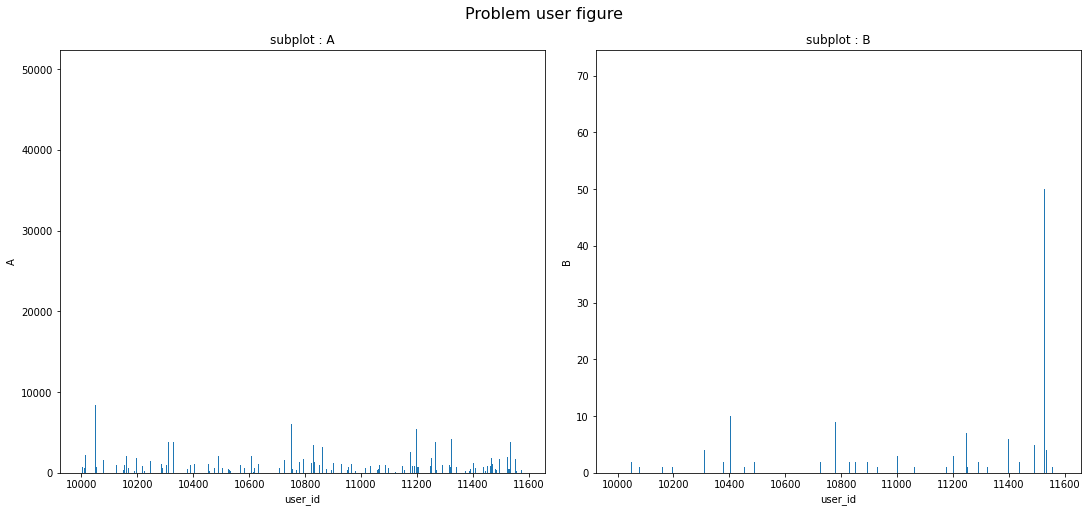

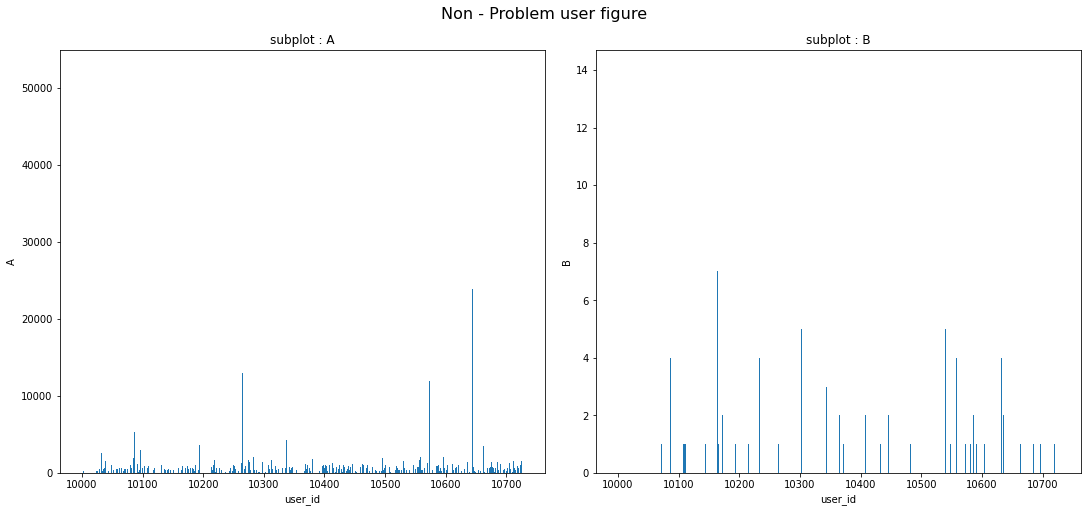

In [ ]:
pro_df = df[df['problem'] == 1][:500]
col = ['A','B']
fig, axs = plt.subplots(1, 2, constrained_layout=True,figsize=(15,7))
x = pro_df['user_id'].to_numpy()
for i in range(2):
  y = pro_df[col[i]].to_numpy()
  axs[i].bar(x, y)
  axs[i].set_title(f'subplot : {col[i]}')
  axs[i].set_xlabel('user_id')
  axs[i].set_ylabel(f'{col[i]}')
  fig.suptitle('Problem user figure', fontsize=16)
plt.show()

print()
print()
pro_df = df[df['problem'] == 0][:500]
col = ['A','B']
fig, axs = plt.subplots(1, 2, constrained_layout=True,figsize=(15,7))
x = pro_df['user_id'].to_numpy()
for i in range(2):
  y = pro_df[col[i]].to_numpy()
  axs[i].bar(x, y)
  axs[i].set_title(f'subplot : {col[i]}')
  axs[i].set_xlabel('user_id')
  axs[i].set_ylabel(f'{col[i]}')
  fig.suptitle('Non - Problem user figure', fontsize=16)
  
plt.show()

In [ ]:
df

,user_id,err0,err1,err2,err3,err4,err5,err6,err7,err8,err9,err10,err11,err12,err13,err14,err15,err16,err17,err18,err19,err20,err21,err22,err23,err24,err25,err26,err27,err28,err29,err30,err31,err32,err33,err34,err35,err36,err37,err38,...,04.33.1095,04.33.1125,04.33.1149,04.33.1171,04.33.1185,04.33.1261,04.73.2237,04.73.2569,04.73.2571,04.73.2577,04.82.1684,04.82.1730,04.82.1778,05.15.2090,05.15.2092,05.15.2114,05.15.2120,05.15.2122,05.15.2138,05.15.3104,05.66.3237,05.66.3571,10,10.22.1770,10.22.1780,8.5.3,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,problem
0,10000,0.0,0.0,8.0,104.0,0.0,1.0,1.0,0.0,0.0,7.0,15.0,16.0,1.0,10.0,59.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,144.0,0.0,0.0,0.0
1,10001,0.0,0.0,0.0,0.0,53.0,1.0,1.0,0.0,0.0,0.0,10.0,11.0,1.0,15.0,151.0,128.0,0.0,4.0,1.0,3.0,1.0,756.0,751.0,5.0,1.0,22.0,0.0,0.0,0.0,0.0,250.0,0.0,10.0,18.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,10002,0.0,0.0,2.0,132.0,1.0,2.0,1.0,0.0,0.0,1.0,13.0,14.0,1.0,4.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,25.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.0,2.0,0.0,0.0,0.0,0.0,27.0,44.0,552.0,0.0,0.0,372.0,0.0,0.0,0.0
3,10003,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0,52.0,30.0,1.0,0.0,0.0,0.0,0.0,28.0,19.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,65.0,0.0,8.0,0.0,0.0,1.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10004,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,16.0,19.0,3.0,5.0,143.0,91.0,0.0,0.0,0.0,0.0,0.0,140.0,119.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,176.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,87.0,1044.0,0.0,0.0,36.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,24995,0.0,0.0,0.0,0.0,2.0,5.0,5.0,0.0,0.0,0.0,5.0,10.0,8.0,8.0,26.0,18.0,0.0,0.0,0.0,0.0,0.0,17.0,12.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,31.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0
14996,24996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,24997,0.0,0.0,0.0,1.0,8.0,1.0,1.0,0.0,0.0,0.0,16.0,18.0,4.0,1.0,181.0,138.0,0.0,0.0,0.0,0.0,0.0,50.0,29.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,223.0,0.0,16.0,17.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,228.0,0.0,0.0,1.0
14998,24998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,15.0,0.0,1.0,51.0,12.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,14.0,0.0,15.0,12.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [43]:
"""
 학습에 사용되는 모든 컬럼
"""
all_data_col_err = ['err0', 'err1', 'err2', 'err3', 'err4', 'err5', 'err6', 'err7', 'err8', 'err9', 'err10', 
                    'err11', 'err12', 'err13', 'err14', 'err15', 'err16', 'err17', 'err18', 'err19', 'err20', 
                    'err21', 'err22', 'err23', 'err24', 'err25', 'err26', 'err27', 'err28', 'err29', 'err30', 
                    'err31', 'err32', 'err33', 'err34', 'err35', 'err36', 'err37', 'err38', 'err39', 'err40', 'err41']
# all_data_col_errcode = ['A','B','C','D','UNKNOWN']
all_data_col_errcode = ['A','B']
all_data_col_err_weekday = ['err_week_0', 'err_week_1', 'err_week_2', 'err_week_3', 'err_week_4', 'err_week_5', 'err_week_6']
all_data_col_err_hours = ['err_hours_0', 'err_hours_1', 'err_hours_2', 'err_hours_3', 'err_hours_4', 'err_hours_5', 'err_hours_6', 
                          'err_hours_7', 'err_hours_8', 'err_hours_9', 'err_hours_10', 'err_hours_11', 'err_hours_12', 'err_hours_13', 
                          'err_hours_14', 'err_hours_15', 'err_hours_16', 'err_hours_17', 'err_hours_18', 'err_hours_19', 'err_hours_20', 
                          'err_hours_21', 'err_hours_22', 'err_hours_23']

all_data_col_model = ['model_0', 'model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6', 'model_7', 'model_8']
all_data_col_fwver = ['03.11.1141', '03.11.1149', '03.11.1167', '04.16.2641', '04.16.3345', '04.16.3439', 
                      '04.16.3553', '04.16.3569', '04.16.3571', '04.22.1170', '04.22.1442', '04.22.1448', 
                      '04.22.1478', '04.22.1608', '04.22.1656', '04.22.1666', '04.22.1684', '04.22.1750', 
                      '04.22.1772', '04.22.1778', '04.33.1095', '04.33.1125', '04.33.1149', '04.33.1171', 
                      '04.33.1185', '04.33.1261', '04.73.2237', '04.73.2569', '04.73.2571', '04.73.2577', 
                      '04.82.1684', '04.82.1730', '04.82.1778', '05.15.2090', '05.15.2092', '05.15.2114', 
                      '05.15.2120', '05.15.2122', '05.15.2138', '05.15.3104', '05.66.3237', '05.66.3571', 
                      '10', '10.22.1770', '10.22.1780', '8.5.3']


all_data_col_qual = ['quality_0', 'quality_1', 'quality_2', 'quality_3', 'quality_4', 'quality_5', 'quality_6', 
                     'quality_7', 'quality_8', 'quality_9', 'quality_10', 'quality_11', 'quality_12']
all_data_col_qual_weekday = ['qual_week_0', 'qual_week_1', 'qual_week_2', 'qual_week_3', 'qual_week_4', 'qual_week_5', 'qual_week_6']
all_data_col_qual_hours = ['qual_hours_0', 'qual_hours_1', 'qual_hours_2', 'qual_hours_3', 'qual_hours_4', 'qual_hours_5', 'qual_hours_6', 
                           'qual_hours_7', 'qual_hours_8', 'qual_hours_9', 'qual_hours_10', 'qual_hours_11', 'qual_hours_12', 'qual_hours_13', 
                           'qual_hours_14', 'qual_hours_15', 'qual_hours_16', 'qual_hours_17', 'qual_hours_18', 'qual_hours_19', 'qual_hours_20', 
                           'qual_hours_21', 'qual_hours_22', 'qual_hours_23']


all_data_columns = ['user_id'] + all_data_col_err + all_data_col_errcode + all_data_col_model + all_data_col_fwver + all_data_col_qual

In [61]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/DACON/LG_predict_complain/20210203_train_data_merge_2.csv')
df.drop(['user_id'],axis=1,inplace=True)
df.drop(all_data_col_fwver,axis=1,inplace=True)
df

,err0,err1,err2,err3,err4,err5,err6,err7,err8,err9,err10,err11,err12,err13,err14,err15,err16,err17,err18,err19,err20,err21,err22,err23,err24,err25,err26,err27,err28,err29,err30,err31,err32,err33,err34,err35,err36,err37,err38,err39,...,err_hours_9,err_hours_10,err_hours_11,err_hours_12,err_hours_13,err_hours_14,err_hours_15,err_hours_16,err_hours_17,err_hours_18,err_hours_19,err_hours_20,err_hours_21,err_hours_22,err_hours_23,qual_hours_0,qual_hours_1,qual_hours_2,qual_hours_3,qual_hours_4,qual_hours_5,qual_hours_6,qual_hours_7,qual_hours_8,qual_hours_9,qual_hours_10,qual_hours_11,qual_hours_12,qual_hours_13,qual_hours_14,qual_hours_15,qual_hours_16,qual_hours_17,qual_hours_18,qual_hours_19,qual_hours_20,qual_hours_21,qual_hours_22,qual_hours_23,problem
0,0.0,0.0,8.0,104.0,0.0,1.0,1.0,0.0,0.0,7.0,15.0,16.0,1.0,10.0,59.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,8.0,5.0,5.0,0.0,10.0,9.0,6.0,15.0,19.0,12.0,0.0,10.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,53.0,1.0,1.0,0.0,0.0,0.0,10.0,11.0,1.0,15.0,151.0,128.0,0.0,4.0,1.0,3.0,1.0,756.0,751.0,5.0,1.0,22.0,0.0,0.0,0.0,0.0,250.0,0.0,10.0,18.0,0.0,1.0,1.0,0.0,0.0,113.0,...,57.0,28.0,83.0,160.0,169.0,183.0,193.0,210.0,153.0,85.0,230.0,176.0,258.0,70.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,2.0,132.0,1.0,2.0,1.0,0.0,0.0,1.0,13.0,14.0,1.0,4.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,25.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,20.0,8.0,0.0,6.0,4.0,27.0,5.0,6.0,5.0,28.0,24.0,30.0,13.0,10.0,12.0,36.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0,52.0,30.0,1.0,0.0,0.0,0.0,0.0,28.0,19.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,65.0,0.0,8.0,0.0,0.0,1.0,1.0,2.0,0.0,17.0,...,4.0,12.0,1.0,3.0,0.0,0.0,8.0,3.0,5.0,5.0,19.0,39.0,30.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,16.0,19.0,3.0,5.0,143.0,91.0,0.0,0.0,0.0,0.0,0.0,140.0,119.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,176.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,...,30.0,10.0,8.0,11.0,36.0,8.0,7.0,18.0,22.0,69.0,111.0,43.0,31.0,70.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,0.0,0.0,0.0,2.0,5.0,5.0,0.0,0.0,0.0,5.0,10.0,8.0,8.0,26.0,18.0,0.0,0.0,0.0,0.0,0.0,17.0,12.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,31.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,7.0,6.0,0.0,12.0,6.0,0.0,14.0,11.0,11.0,20.0,4.0,14.0,18.0,16.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0
14996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,0.0,0.0,1.0,8.0,1.0,1.0,0.0,0.0,0.0,16.0,18.0,4.0,1.0,181.0,138.0,0.0,0.0,0.0,0.0,0.0,50.0,29.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,223.0,0.0,16.0,17.0,0.0,1.0,1.0,0.0,0.0,58.0,...,56.0,9.0,16.0,25.0,14.0,8.0,8.0,11.0,16.0,35.0,19.0,65.0,39.0,62.0,41.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,1.0
14998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,15.0,0.0,1.0,51.0,12.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(300,300))
sns.heatmap(data = df.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')


Output hidden; open in https://colab.research.google.com to view.

In [63]:
df_corr = df.corr()

In [64]:
print(list(df_corr[df_corr.problem.isna()].index))

['err28', 'quality_3', 'quality_4', 'quality_minus_3', 'quality_minus_4', 'quality_minus_7', 'quality_minus_8', 'quality_minus_9', 'quality_minus_10', 'quality_minus_12']


In [65]:
drop_list = ['err28', 'quality_3', 'quality_4', 'quality_minus_3', 'quality_minus_4', 'quality_minus_7', 'quality_minus_8', 'quality_minus_9', 'quality_minus_10', 'quality_minus_12']


In [66]:
df.drop(drop_list, axis=1,inplace=True)


In [67]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(250,250))
sns.heatmap(data = df.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')


Output hidden; open in https://colab.research.google.com to view.

In [73]:
df

,err0,err1,err2,err3,err4,err5,err6,err7,err8,err9,err10,err11,err12,err13,err14,err15,err16,err17,err18,err19,err20,err21,err22,err23,err24,err25,err26,err27,err29,err30,err31,err32,err33,err34,err35,err36,err37,err38,err39,err40,...,err_hours_9,err_hours_10,err_hours_11,err_hours_12,err_hours_13,err_hours_14,err_hours_15,err_hours_16,err_hours_17,err_hours_18,err_hours_19,err_hours_20,err_hours_21,err_hours_22,err_hours_23,qual_hours_0,qual_hours_1,qual_hours_2,qual_hours_3,qual_hours_4,qual_hours_5,qual_hours_6,qual_hours_7,qual_hours_8,qual_hours_9,qual_hours_10,qual_hours_11,qual_hours_12,qual_hours_13,qual_hours_14,qual_hours_15,qual_hours_16,qual_hours_17,qual_hours_18,qual_hours_19,qual_hours_20,qual_hours_21,qual_hours_22,qual_hours_23,problem
0,0.0,0.0,8.0,104.0,0.0,1.0,1.0,0.0,0.0,7.0,15.0,16.0,1.0,10.0,59.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,8.0,5.0,5.0,0.0,10.0,9.0,6.0,15.0,19.0,12.0,0.0,10.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,53.0,1.0,1.0,0.0,0.0,0.0,10.0,11.0,1.0,15.0,151.0,128.0,0.0,4.0,1.0,3.0,1.0,756.0,751.0,5.0,1.0,22.0,0.0,0.0,0.0,250.0,0.0,10.0,18.0,0.0,1.0,1.0,0.0,0.0,113.0,56.0,...,57.0,28.0,83.0,160.0,169.0,183.0,193.0,210.0,153.0,85.0,230.0,176.0,258.0,70.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,2.0,132.0,1.0,2.0,1.0,0.0,0.0,1.0,13.0,14.0,1.0,4.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,25.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,20.0,8.0,0.0,6.0,4.0,27.0,5.0,6.0,5.0,28.0,24.0,30.0,13.0,10.0,12.0,36.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0,52.0,30.0,1.0,0.0,0.0,0.0,0.0,28.0,19.0,0.0,0.0,59.0,0.0,0.0,0.0,65.0,0.0,8.0,0.0,0.0,1.0,1.0,2.0,0.0,17.0,1.0,...,4.0,12.0,1.0,3.0,0.0,0.0,8.0,3.0,5.0,5.0,19.0,39.0,30.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,16.0,19.0,3.0,5.0,143.0,91.0,0.0,0.0,0.0,0.0,0.0,140.0,119.0,0.0,0.0,33.0,0.0,0.0,0.0,176.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0,...,30.0,10.0,8.0,11.0,36.0,8.0,7.0,18.0,22.0,69.0,111.0,43.0,31.0,70.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,0.0,0.0,0.0,2.0,5.0,5.0,0.0,0.0,0.0,5.0,10.0,8.0,8.0,26.0,18.0,0.0,0.0,0.0,0.0,0.0,17.0,12.0,0.0,0.0,22.0,0.0,0.0,0.0,31.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,7.0,...,0.0,7.0,6.0,0.0,12.0,6.0,0.0,14.0,11.0,11.0,20.0,4.0,14.0,18.0,16.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0
14996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,0.0,0.0,1.0,8.0,1.0,1.0,0.0,0.0,0.0,16.0,18.0,4.0,1.0,181.0,138.0,0.0,0.0,0.0,0.0,0.0,50.0,29.0,0.0,0.0,49.0,0.0,0.0,0.0,223.0,0.0,16.0,17.0,0.0,1.0,1.0,0.0,0.0,58.0,8.0,...,56.0,9.0,16.0,25.0,14.0,8.0,8.0,11.0,16.0,35.0,19.0,65.0,39.0,62.0,41.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,1.0
14998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,15.0,0.0,1.0,51.0,12.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0